<h1><center>30-Day Mortality Prediction for Hospital Admissions</center></h1>
<h2><center>BME590 Data Science and Health Final Project</center></h2>

This project is hosted on GitHub at: https://github.com/sputney13/30-Day-Mortality

## Overview & Background

The 30-day mortality rate is one measure used to compare hospital's effectiveness of care. It is an estimate of the proportion of patients that die within 30 days of being admitted to the hospital for a specific condition. The death can be for any reason, and can occur after patient discharge. This measure uses 30 days as the cutoff for mortality because after 30 days, deaths are less likely to be caused by hospital care and more likely to be caused by other illnesses, the patient's behaviors, or other sources of care. Some calculations of 30-day mortality rate (for example, the rates computed by the Centers for Medicare and Medicare Services) adjust for the risk of patient death prior to hospital admission, including age and prior conditions / comorbidities that increase the likelihood of death.

The 30-day mortality rate is considered an "outcome of care" measure, in that it provides an indication to patients, physicians, and regulatory bodies of how well a hospital prevents further complications, educates patients about their health needs, and helps patients transition out of hospital care. A hospital should aim to lower this rate to ensure that quality of patient care is improved while simultaneously ensuring that patients do not spend more time in the hospital than medically necessary. Therefore, it is to a hospital's advantage to identify patients at risk of 30 day mortality early during their hospital stay in order to provide more attentive and personalized care and ideally lower their risk.

This project will utilize data from the MIMIC-III Clinical Database, a database containing health data for over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012. Each eligible admission will be flagged if the patient died within 30 days of the admission date, and various factors in the patients' stay will serve as variables for fitting a predictive model to the data. Because a predictive model for 30-day mortality is primarily useful in the early stage of an admission (before an at-risk patient would die), data used as variables for modeling was limited to static information obtained at the patient's admission time. Though other data obtained within the first 24 hours of a patient's stay (for example, chart data or lab results) may also prove predictive of 30-day mortality rate, the purpose of this model is to attempt to flag new admissions as likely (or unlikely) to die within 30 days of admission at the moment they are admitted to the hospital. Assessment of the model will consider its ROC-AUC score, average precision, and accuracy. A useful model will have an accuracy higher than proportion of admissions in the data that did not result in patient death within 30 days (that is, the model will perform better than random chance). For the admissions included in this model, the 30-day mortality rate was 13.6%, so the accuracy benchmark for my model will be 86.4%.

## Data

Each admission will be considered its own data point when coding for the binary classification of death within 30 days of admission date or not. To this end, the variables considered for use in the model should be accessible per admission in the admissions table (ADMISSIONS.CSV). Variables of interest include admission type, patient insurance, ethnicity, and marital status (from the admissions table), ICD-9 codes converted to CCS Categories associated with the admission (from the diagnoses ICD table), patient gender and age (from the patients table), and the (first) type of ICU admitted to, if a patient is transferred to an ICU within 3 hours of their admission. (from the ICU stays table).

In [1]:
import pandas as pd
import numpy as np

admissions_df = pd.read_csv("./data/ADMISSIONS.csv")
patients_df = pd.read_csv("./data/PATIENTS.csv")
diagnosis_df = pd.read_csv("./data/DIAGNOSES_ICD.csv")
icu_df = pd.read_csv("./data/ICUSTAYS.csv")

### Admissions

I will begin by cleaning the admissions table, since we will merge all other relavent data into this table.

In [2]:
admissions_df.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

The columns of interest from the admissions dataframe are Subject ID and Hospital Admission ID (for use in joining dataframes later), admit time (to calculate 30-day mortality from), and admission type, insurance, marital status, and ethnicity (for use as variables in the model). Note that death time is not useful here because it only accounts for in-hospital deaths. Language and religion are excluded from variable use due to the large proportion of null/missing values that cannot be reasonably inferred.

In [3]:
admissions_df.drop(['DISCHTIME', 'DEATHTIME', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', "LANGUAGE", "RELIGION", 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'], axis = 1, inplace=True)

In [4]:
admissions_df.dtypes

ROW_ID             int64
SUBJECT_ID         int64
HADM_ID            int64
ADMITTIME         object
ADMISSION_TYPE    object
INSURANCE         object
MARITAL_STATUS    object
ETHNICITY         object
dtype: object

In [5]:
admissions_df['ADMITTIME'] = pd.to_datetime(admissions_df['ADMITTIME'])

In [6]:
admissions_df['ADMISSION_TYPE'].value_counts()

EMERGENCY    42071
NEWBORN       7863
ELECTIVE      7706
URGENT        1336
Name: ADMISSION_TYPE, dtype: int64

Admission types codified as 'NEWBORN' are hospital stays related to the patient's birth. The 30-day infant mortality rate for infants that are merely born in a hospital and then released is less likely to be predicted by hospital factors than the rate for adults, so the admissions data related to hospital births will not be included when training the model. Howevever, young patients admitted under the emergency, elective, or urgent banners will be included.

In [7]:
admissions_df = admissions_df[admissions_df['ADMISSION_TYPE'] != 'NEWBORN']
admissions_df['ADMISSION_TYPE'].value_counts()

EMERGENCY    42071
ELECTIVE      7706
URGENT        1336
Name: ADMISSION_TYPE, dtype: int64

In [8]:
admissions_df["ETHNICITY"].value_counts()

WHITE                                                       36222
BLACK/AFRICAN AMERICAN                                       4570
UNKNOWN/NOT SPECIFIED                                        4075
HISPANIC OR LATINO                                           1324
OTHER                                                        1144
ASIAN                                                         793
UNABLE TO OBTAIN                                              781
PATIENT DECLINED TO ANSWER                                    450
ASIAN - CHINESE                                               239
HISPANIC/LATINO - PUERTO RICAN                                226
BLACK/CAPE VERDEAN                                            175
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          104
BLACK/HAITIAN                                                  98
ASIAN - ASIAN INDIAN                                           81
HISPANIC/L

To simplify the diverse ethnicities recorded for patients in the database, ethnicity data will be condensed into the following categories: White, Black, Hispanic/Latino, Asian, and Other.

In [9]:
admissions_df.loc[admissions_df['ETHNICITY'].str.contains('WHITE'), 'ETHNICITY'] = 'WHITE'
admissions_df.loc[admissions_df['ETHNICITY'].str.contains('BLACK'), 'ETHNICITY'] = 'BLACK'
admissions_df.loc[admissions_df['ETHNICITY'].str.contains('HISPANIC'), 'ETHNICITY'] = 'HISPANIC/LATINO'
admissions_df.loc[admissions_df['ETHNICITY'].str.contains('ASIAN'), 'ETHNICITY'] = 'ASIAN'
admissions_df['ETHNICITY'].where(admissions_df['ETHNICITY'].isin(['WHITE', 'BLACK', 'HISPANIC/LATINO', 'ASIAN']), 'OTHER/UNKNOWN', inplace=True)
admissions_df['ETHNICITY'].value_counts()

WHITE              36542
OTHER/UNKNOWN       6710
BLACK               4883
HISPANIC/LATINO     1743
ASIAN               1235
Name: ETHNICITY, dtype: int64

In [10]:
admissions_df['MARITAL_STATUS'].value_counts()

MARRIED              24236
SINGLE               12950
WIDOWED               7211
DIVORCED              3213
SEPARATED              571
UNKNOWN (DEFAULT)      343
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

In [11]:
# replace null values in marital status column with "UNKNOWN"
admissions_df['MARITAL_STATUS'] = admissions_df['MARITAL_STATUS'].replace('UNKNOWN (DEFAULT)', 'UNKNOWN')
admissions_df['MARITAL_STATUS'] = admissions_df['MARITAL_STATUS'].fillna('UNKNOWN')
admissions_df['MARITAL_STATUS'].value_counts()

MARRIED         24236
SINGLE          12950
WIDOWED          7211
DIVORCED         3213
UNKNOWN          2917
SEPARATED         571
LIFE PARTNER       15
Name: MARITAL_STATUS, dtype: int64

In [12]:
admissions_df.dtypes

ROW_ID                     int64
SUBJECT_ID                 int64
HADM_ID                    int64
ADMITTIME         datetime64[ns]
ADMISSION_TYPE            object
INSURANCE                 object
MARITAL_STATUS            object
ETHNICITY                 object
dtype: object

The admissions dataframe now contains the following information:
Subject IDs and Hospital IDs for joining data in different tables, admit times (as a datetime data type), admission type (3 string options), insurance (5 string options), marital status (7 string options), and ethnicity (5 string options). For these string-type variables, I will utilize One-Hot Encoding to convert each option into its own variable with a binary classification. However, I will perform this step in the modeling phase, to ease in exploratory data analysis.

### Patients

In [13]:
patients_df.columns

Index(['ROW_ID', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN',
       'EXPIRE_FLAG'],
      dtype='object')

The columns of interest in the patients dataframe are Subject ID (to use in merging tables), DOD (Date of Death - to calculate whether or not there was 30 day mortality), Gender, and DOB (Date of Birth - to calculate age at time of admission).

In [14]:
patients_df[['DOB','DOD']] = patients_df[['DOB','DOD']].apply(pd.to_datetime)

In [15]:
patients_df.dtypes

ROW_ID                  int64
SUBJECT_ID              int64
GENDER                 object
DOB            datetime64[ns]
DOD            datetime64[ns]
DOD_HOSP               object
DOD_SSN                object
EXPIRE_FLAG             int64
dtype: object

The relevant data from the patients table should be left-joined onto the admissions table on the Subject ID column. The DOB column can then be converted into an Age (at time of admission) column.

In [16]:
admissions_df = pd.merge(admissions_df, patients_df[["SUBJECT_ID", "GENDER", "DOB", "DOD"]], on="SUBJECT_ID", how="left")
admissions_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,ADMISSION_TYPE,INSURANCE,MARITAL_STATUS,ETHNICITY,GENDER,DOB,DOD
0,21,22,165315,2196-04-09 12:26:00,EMERGENCY,Private,MARRIED,WHITE,F,2131-05-07,NaT
1,22,23,152223,2153-09-03 07:15:00,ELECTIVE,Medicare,MARRIED,WHITE,M,2082-07-17,NaT
2,23,23,124321,2157-10-18 19:34:00,EMERGENCY,Medicare,MARRIED,WHITE,M,2082-07-17,NaT
3,24,24,161859,2139-06-06 16:14:00,EMERGENCY,Private,SINGLE,WHITE,M,2100-05-31,NaT
4,25,25,129635,2160-11-02 02:06:00,EMERGENCY,Private,MARRIED,WHITE,M,2101-11-21,NaT


To comply with HIPPA guidelines, the MIMIC-III database adjusted DOB values for patients over the age of 89 to limit the likelihood of patient identification. These adjustments were made to approximately 300 years after the admission date. To address this quirk, patient age will be separated into deciles and assigned an integer value- for example, ages [10-20) will be coded with a 1 and ages [20-30) will be coded with a 2. The last group will be ages 90 and up.

In [17]:
admissions_df['DOB'] = np.abs(admissions_df['ADMITTIME'].subtract(admissions_df['DOB']).dt.days / 365)
admissions_df = admissions_df.rename(columns={"DOB": "AGE"})

In [18]:
admissions_df['AGE'] = np.where(admissions_df['AGE'] < 10, 0, admissions_df['AGE'])
admissions_df['AGE'] = np.where(admissions_df['AGE'].between(10.0,20.0), 1, admissions_df['AGE'])
admissions_df['AGE'] = np.where(admissions_df['AGE'].between(20.0,30.0), 2, admissions_df['AGE'])
admissions_df['AGE'] = np.where(admissions_df['AGE'].between(30.0,40.0), 3, admissions_df['AGE'])
admissions_df['AGE'] = np.where(admissions_df['AGE'].between(40.0,50.0), 4, admissions_df['AGE'])
admissions_df['AGE'] = np.where(admissions_df['AGE'].between(50.0,60.0), 5, admissions_df['AGE'])
admissions_df['AGE'] = np.where(admissions_df['AGE'].between(60.0,70.0), 6, admissions_df['AGE'])
admissions_df['AGE'] = np.where(admissions_df['AGE'].between(70.0,80.0), 7, admissions_df['AGE'])
admissions_df['AGE'] = np.where(admissions_df['AGE'].between(80.0,90.0), 8, admissions_df['AGE'])
admissions_df['AGE'] = np.where(admissions_df['AGE'] > 90, 9, admissions_df['AGE'])
admissions_df['AGE'].value_counts()

6.0    10616
7.0    10450
5.0     8882
8.0     7683
4.0     5467
3.0     2716
9.0     2616
2.0     2049
1.0      387
0.0      247
Name: AGE, dtype: int64

### Creating the 30-Day Mortality Label

Admissions that do not have a DOD listed, or whose DOD did not occur within 30 days of the admit time, will be flagged with a 0, and those with a 30-day mortality will be flagged with a 1.

In [19]:
admissions_df['30_DAY_MORT'] = np.zeros(admissions_df.shape[0])
admissions_df['30_DAY_MORT'] = np.where((admissions_df['DOD'].subtract(admissions_df['ADMITTIME'])).dt.days < 30, 1, admissions_df['30_DAY_MORT'])
admissions_df['30_DAY_MORT'].value_counts()

0.0    44182
1.0     6931
Name: 30_DAY_MORT, dtype: int64

13.6% of admissions resulted in 30-day mortality. Therefore, the benchmark for my model is 86.4% accuracy, or, the accuracy that would be achieved by predicting no mortality for each admission.

In [20]:
admissions_df.drop(['DOD', 'ROW_ID', 'SUBJECT_ID'], axis=1, inplace=True)
admissions_df.head()

,HADM_ID,ADMITTIME,ADMISSION_TYPE,INSURANCE,MARITAL_STATUS,ETHNICITY,GENDER,AGE,30_DAY_MORT
0,165315,2196-04-09 12:26:00,EMERGENCY,Private,MARRIED,WHITE,F,6.0,0.0
1,152223,2153-09-03 07:15:00,ELECTIVE,Medicare,MARRIED,WHITE,M,7.0,0.0
2,124321,2157-10-18 19:34:00,EMERGENCY,Medicare,MARRIED,WHITE,M,7.0,0.0
3,161859,2139-06-06 16:14:00,EMERGENCY,Private,SINGLE,WHITE,M,3.0,0.0
4,129635,2160-11-02 02:06:00,EMERGENCY,Private,MARRIED,WHITE,M,5.0,0.0


### Diagnosis ICD-9 Codes

In [21]:
diagnosis_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [22]:
diagnosis_df.dropna(inplace=True) # any NaN ICD9 codes will not prove useful and are thus being removed

In [23]:
len(pd.unique(diagnosis_df['ICD9_CODE']))

6984

To reduce the number of unique ICD9 Codes found in the admissions data down to a number more manageable for prediction (and to reduce the overall sparsity of the data), I will convert all ICD9 Codes into their correspondent ICD-9-CM single level CCS (H-CUP, 2017).

In [24]:
# Credit to Michael Gao, Duke BME590 Data Science and Health (Homework 2) for the idea to use CCS categories to lump ICD9 codes
ccs_df = pd.read_csv('./data/$dxref 2015.csv', skiprows=1)

# Clean column names by removing whitespace and quotes
ccs_df.rename(columns=lambda x: x.strip(), inplace=True)
ccs_df.rename(columns=lambda x: x.replace("'", ""), inplace=True)

# Clean data in the ICD9 Codes and CCS category columns by removing whitespace and quotes
ccs_df['ICD-9-CM CODE'] = ccs_df['ICD-9-CM CODE'].str.replace(" ", "")
ccs_df['ICD-9-CM CODE'] = ccs_df['ICD-9-CM CODE'].str.replace("'", "")

# CCS Category descriptions were chosen over the more succint numerical category identifiers
# because all categories will eventually become their own variable - string titles will improve understandability
ccs_df['CCS CATEGORY DESCRIPTION'] = ccs_df['CCS CATEGORY DESCRIPTION'].str.replace(" ", "")
ccs_df['CCS CATEGORY DESCRIPTION'] = ccs_df['CCS CATEGORY DESCRIPTION'].str.replace("'", "")

In [25]:
# left join of ICD9 codes with CCS category
diagnosis_df = pd.merge(diagnosis_df, ccs_df[['ICD-9-CM CODE', 'CCS CATEGORY DESCRIPTION']], left_on = ['ICD9_CODE'], right_on = ['ICD-9-CM CODE'], how='left')

In [26]:
diagnosis_df.drop(['ROW_ID','SUBJECT_ID', 'SEQ_NUM', 'ICD9_CODE', 'ICD-9-CM CODE'], axis=1, inplace=True)

# remove duplicate CCS categories for same admission (multiple ICD9 codes under one category)
diagnosis_df.drop_duplicates(inplace=True)

In [27]:
len(pd.unique(diagnosis_df['CCS CATEGORY DESCRIPTION']))

282

Using CCS categories reduces the number of unique diagnosis codes in the dataset from nearly 7000 to 282. Reducing the sparsity of the data will assist in the model's predictivity. Later I will merge this data into the admissions table using One-Hot Encoding to convert each option into its own variable with a binary classification. I will then use sklearn's feature selection tools to reduce the number of variables down to the most relevant.

### ICU Stays

The final variable used in the model will be if the patient was admitted to an ICU unit within 3 hours of hospital admission (3 hours is used to allow for a slight delay between recording the patient as entering the hospital and their respective transfer to a bed in an ICU). 

In [28]:
icu_df.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE',
       'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID',
       'INTIME', 'OUTTIME', 'LOS'],
      dtype='object')

In [29]:
icu_df['INTIME'] = pd.to_datetime(icu_df['INTIME'])

In [30]:
admissions_df = pd.merge(admissions_df, icu_df[['HADM_ID', 'FIRST_CAREUNIT', 'INTIME']], on='HADM_ID', how='left')

In [31]:
# Patients with NaN values in their ICU stay were not admitted to an ICU during their admission
admissions_df['FIRST_CAREUNIT'].fillna("NONE", inplace=True)

In [32]:
# if time of ICU admission is not within 3 hours of hospital admission, change ICU unit to "None"
admissions_df['FIRST_CAREUNIT'] = np.where((admissions_df['INTIME'].subtract(admissions_df['ADMITTIME'])).dt.days > 0.125, "NONE", admissions_df['FIRST_CAREUNIT'])

In [33]:
admissions_df['FIRST_CAREUNIT'].value_counts()

MICU     16773
NONE     14571
SICU      6328
CCU       5983
CSRU      5726
TSICU     5151
NICU       219
Name: FIRST_CAREUNIT, dtype: int64

This gives 7 potential options for the ICU the patient is admitted to within the first 3 hours of their hospital stay: MICU, SICU, CCU, CSRU, TSISCU, NICU, or none.

In [34]:
admissions_df.drop(['ADMITTIME', 'INTIME'], axis=1, inplace=True)
admissions_df.rename(columns={"FIRST_CAREUNIT": "ICU"}, inplace=True)

In [35]:
admissions_df.head()

,HADM_ID,ADMISSION_TYPE,INSURANCE,MARITAL_STATUS,ETHNICITY,GENDER,AGE,30_DAY_MORT,ICU
0,165315,EMERGENCY,Private,MARRIED,WHITE,F,6.0,0.0,MICU
1,152223,ELECTIVE,Medicare,MARRIED,WHITE,M,7.0,0.0,CSRU
2,124321,EMERGENCY,Medicare,MARRIED,WHITE,M,7.0,0.0,NONE
3,161859,EMERGENCY,Private,SINGLE,WHITE,M,3.0,0.0,CCU
4,129635,EMERGENCY,Private,MARRIED,WHITE,M,5.0,0.0,CCU


### Summary of Cleaned Data

There are two summary matrices that will be further used in data analysis and modeling: admissions_df and diagnosis_df. The admissions table contains the hospital admission ID (for final merging of the two tables), information for the admission type, insurance, marital status, ethnicity, gender, age, and ICU type variables, and the 30-day mortality flag for each admission. The diagnosis table contains the CCS categories registered for each hospital admission.

There are 8 categories of variables to test: admission type, insurance type, marital status, ethnicity, gender, age, ICU stay type, and CCS categories listed. Aside from the normalized age brackets, all of these categories are non-numeric and will need to be one hot encoded in order for use in a predictive model. After one hot encoding, there will be 312 variables to test (3 admission types, 5 insurance types, 7 marital statuses, 5 ethnicities, 2 genders, age, 7 ICU stay types, and 282 unique CCS categories). I will test using all variables against using variable selection tools from the sklearn package to limit the variables to those which are most impactful on the predictive model.

## Exploratory Data Analysis

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

I wanted to view the distribution of the 6 variable categories above that are non-numeric and have a reasonable number of options for plotting purposes. I chose to represent these distributions as labeled slices in 6 individual pie charts. This visualization is useful in noting where there may be sparsity in the variable matrix when performing one hot encoding (one particular example is the 'Life Partner' option in the 'Marital Status' variable, which has such few entries that it registers as 0.0% on the pie chart below). It is also interesting to compare these data to population norms - it appears as though this particular dataset may overrepresent white and male patients compared to the general population. However, this may be indicative that the variable is of interest when prediciting at-risk patients.

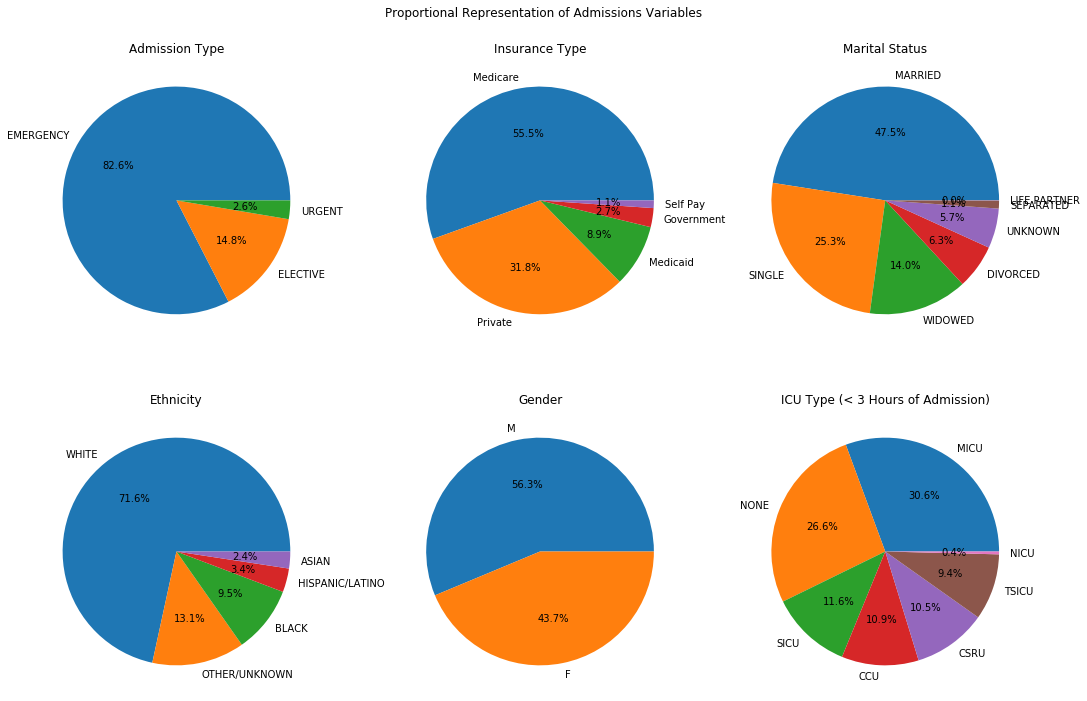

In [37]:
fig, axs = plt.subplots(2, 3, figsize=(15,10), constrained_layout=True)

fig.suptitle('Proportional Representation of Admissions Variables')

axs[0,0].pie(admissions_df['ADMISSION_TYPE'].value_counts(), labels=admissions_df['ADMISSION_TYPE'].value_counts().index, autopct='%1.1f%%')
axs[0,0].set_title('Admission Type')

axs[0,1].pie(admissions_df['INSURANCE'].value_counts(), labels=admissions_df['INSURANCE'].value_counts().index, autopct='%1.1f%%')
axs[0,1].set_title('Insurance Type')

axs[0,2].pie(admissions_df['MARITAL_STATUS'].value_counts(), labels=admissions_df['MARITAL_STATUS'].value_counts().index, autopct='%1.1f%%')
axs[0,2].set_title('Marital Status')

axs[1,0].pie(admissions_df['ETHNICITY'].value_counts(), labels=admissions_df['ETHNICITY'].value_counts().index, autopct='%1.1f%%')
axs[1,0].set_title('Ethnicity')

axs[1,1].pie(admissions_df['GENDER'].value_counts(), labels=admissions_df['GENDER'].value_counts().index, autopct='%1.1f%%')
axs[1,1].set_title('Gender')

axs[1,2].pie(admissions_df['ICU'].value_counts(), labels=admissions_df['ICU'].value_counts().index, autopct='%1.1f%%')
axs[1,2].set_title('ICU Type (< 3 Hours of Admission)')

plt.show()

As shown below, age distribution for the admissions data was predictably right-skewed towards patients in larger age-deciles. This right skew is even more pronounced in the admissions that resulted in 30-day mortality, where the peak resides in the 70-80 decile and the 0-10 decile completely disappears.

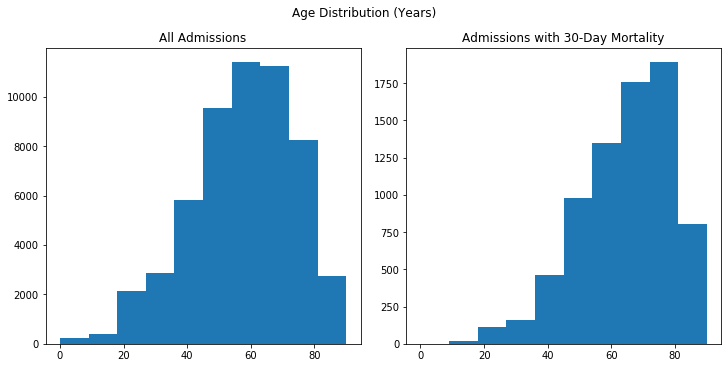

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True)

fig.suptitle('Age Distribution (Years)')

axs[0].hist(admissions_df['AGE']*10)
axs[0].set_title('All Admissions')

flagged_adm = admissions_df.loc[admissions_df['30_DAY_MORT'] == 1]
axs[1].hist(flagged_adm['AGE']*10)
axs[1].set_title('Admissions with 30-Day Mortality')

plt.show()

When considering which CCS categories might be most predictive for 30-day patient mortality, I considered the prevalence of each CCS category within the dataset. Categories which are less sparse will most likely be more useful for prediction. The top chart below plots the top 10 most prevalent CCS categories in the entire admissions dataframe versus their prevalence, while the bottom does the same but considering only admissions that resulted in 30-day mortality. The top 6 most prevelant CCS categories in the 30-day mortality plot were also in the top 10 for all admissions, however, positions 7-10 for the 30-day mortality plot were not present in the top 10 for all admissions, indicating that those categories may be variables of interest when differentiating a 30-day mortality admission from other data.

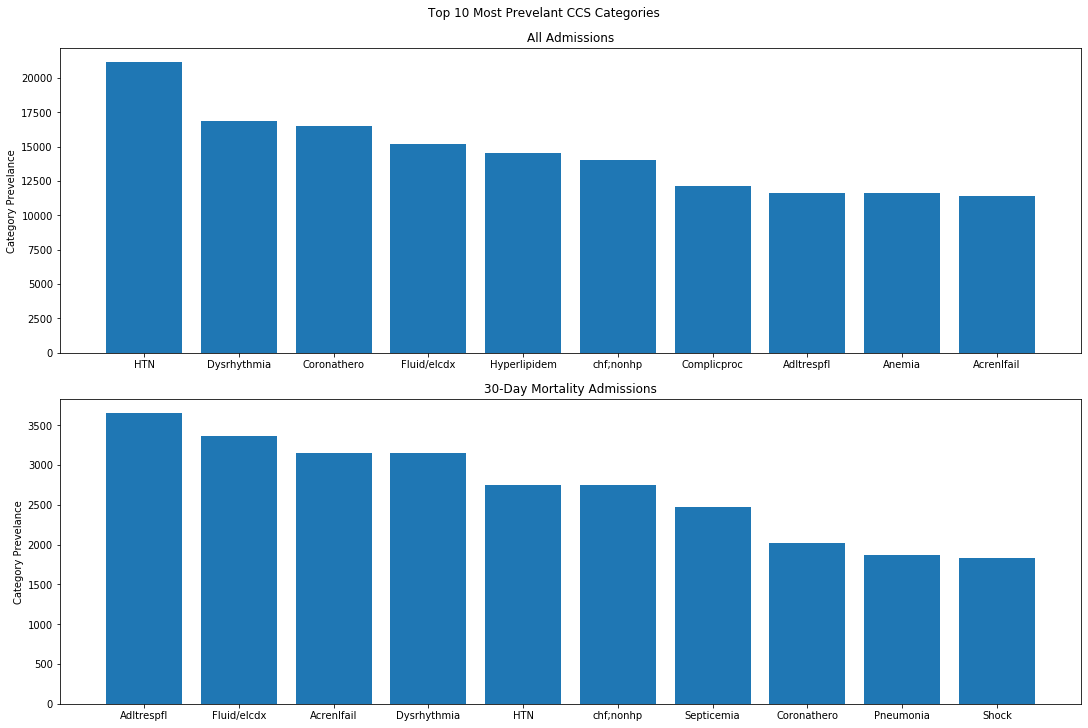

In [39]:
fig, axs = plt.subplots(2, 1, figsize=(15,10), constrained_layout=True)

fig.suptitle('Top 10 Most Prevelant CCS Categories')

# group all diagnoses by CCS category, and sort by size in ascending order to select top 10
cats_df = pd.DataFrame({'CCS_CATS': diagnosis_df.groupby('CCS CATEGORY DESCRIPTION').size()})
values = cats_df['CCS_CATS'].sort_values(ascending=False)[0:10]
labels = cats_df['CCS_CATS'].sort_values(ascending=False).index[0:10]

axs[0].bar(labels, values)
axs[0].set_title('All Admissions')
axs[0].set_ylabel('Category Prevelance')

# merge in 30-day mortality flag to extract diagnoses for patients with 30-day mortality
diag_with_mort = pd.merge(diagnosis_df, admissions_df[['HADM_ID', '30_DAY_MORT']], on='HADM_ID', how='left')
diag_with_mort = diag_with_mort.loc[diag_with_mort['30_DAY_MORT'] == 1]

# group 30-day mortality diagnoses by CCS category, and sort by size in ascending order to select top 10
cats_mort = pd.DataFrame({'CCS_CATS': diag_with_mort.groupby('CCS CATEGORY DESCRIPTION').size()})
values = cats_mort['CCS_CATS'].sort_values(ascending=False)[0:10]
labels = cats_mort['CCS_CATS'].sort_values(ascending=False).index[0:10]

axs[1].bar(labels, values)
axs[1].set_title('30-Day Mortality Admissions')
axs[1].set_ylabel('Category Prevelance')

plt.show()

An interesting question is the role ethnicity may play in diagnosis of comorbidities- I questioned whether certain ethnicities were more likely to be dignosed with ICD9 codes in multiple CCS categories. I chose to represent this data as boxplots of the number of unique CCS categories assigned to an admission, grouped into categorical plots by ethnicity. From the admissions dataset, Black patients tended to receive the most unique CCS categories assigned per admission, while patients in the Other/Unknown race category received the least (followed by Asian patients).

In [40]:
# find number of CCS categories per admission, merge into a new admissions matrix
group_df = pd.DataFrame({'CCS_COUNT': diagnosis_df.groupby('HADM_ID').size()})
adm_ccs_count = pd.merge(admissions_df, group_df, on='HADM_ID', how='left')

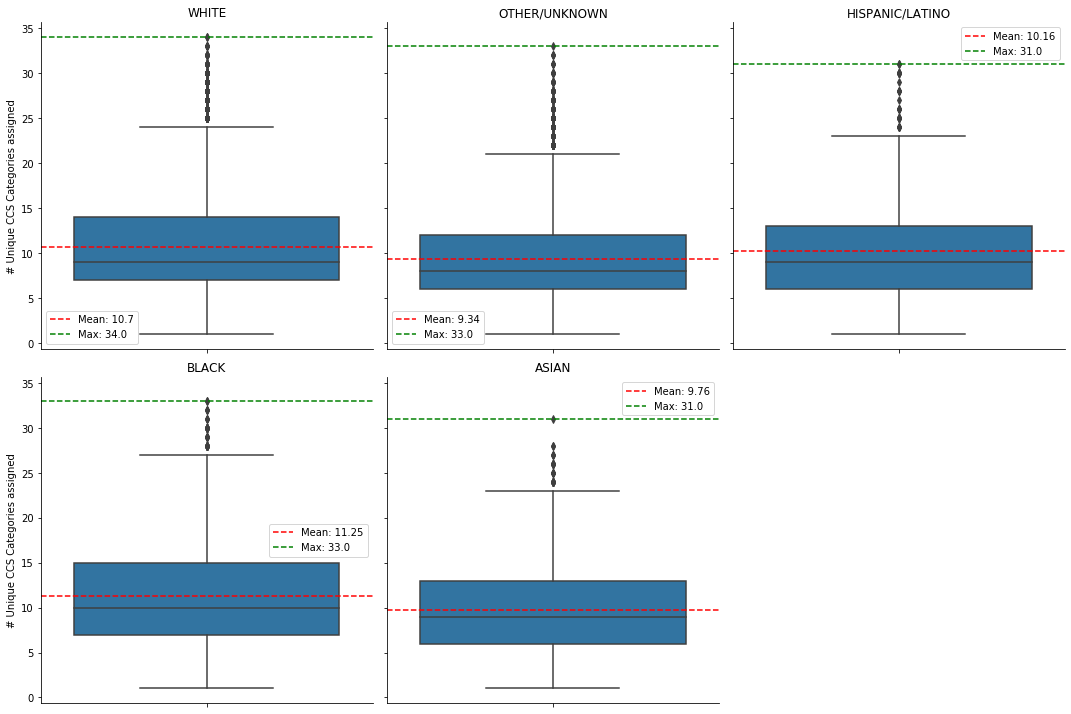

In [41]:
ethnicities = pd.unique(adm_ccs_count['ETHNICITY'])
mean = adm_ccs_count.groupby(['ETHNICITY'])['CCS_COUNT'].mean()
maxes = adm_ccs_count.groupby(['ETHNICITY'])['CCS_COUNT'].max()

# plot CCS count as a box plot, with subplot data grouped by patient ethnicity
plot = sns.catplot(y='CCS_COUNT', data=adm_ccs_count, col='ETHNICITY', kind='box', col_wrap=3)
for i in range(len(plot.axes)):
    ax = plot.axes[i]
    ax.set(title=ethnicities[i])
    if i is 0 or i is 3:
        ax.set(ylabel='# Unique CCS Categories assigned')
    ax.axhline(mean[ethnicities[i]], color='red', linestyle='--', label='Mean: {}'.format(round(mean[ethnicities[i]], 2)))
    ax.axhline(maxes[ethnicities[i]], color='green', linestyle='--', label='Max: {}'.format(maxes[ethnicities[i]]))    
    ax.legend()

An additional area of interest is whether number of unique CCS categories assigned per admission also plays a predictive role in whether an admit experiences 30-day mortality. Per the boxplots below, the admits that died within 30 days of their admission date were diagnosed with approximately 2 more unique CCS categories on average than those that did not experience 30 day mortality.

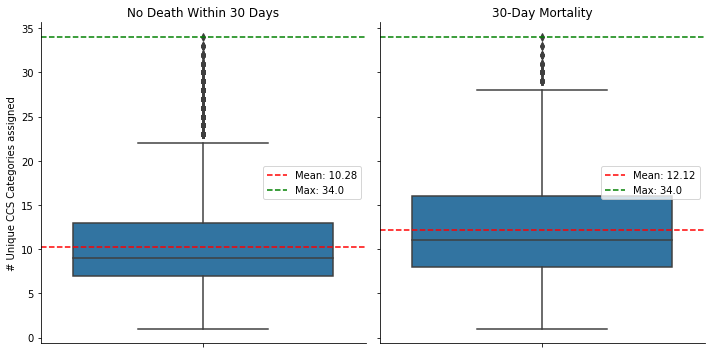

In [42]:
titles= ['No Death Within 30 Days', '30-Day Mortality']
mean = adm_ccs_count.groupby(['30_DAY_MORT'])['CCS_COUNT'].mean()
maxes = adm_ccs_count.groupby(['30_DAY_MORT'])['CCS_COUNT'].max()

# plot CCS count as a box plot, with the 30-day mortality flag used as the subplot grouping
plot = sns.catplot(y='CCS_COUNT', data=adm_ccs_count, col='30_DAY_MORT', kind='box')
for i in range(len(plot.axes[0])):
    a = plot.axes[0][i]
    a.set(title=titles[i])
    if i is 0:
        a.set(ylabel='# Unique CCS Categories assigned')
    a.axhline(mean[i], color='red', linestyle='--', label='Mean: {}'.format(round(mean[i], 2)))
    a.axhline(maxes[i], color='green', linestyle='--', label='Max: {}'.format(maxes[i]))
    a.legend()

The exploratory data analysis performed in this section was assistive in creating a greater understanding of the distributions of the variables that may be used in the model, and therefore in understanding which variable types may be too sparse to generate significance in model predictions. It was also useful in elucidating differences in variable values for patients flagged with or without 30-day mortality, which may indicate that those variables may prove more predictive than other options.

## Modeling

### Creating the Model Matrix

To prepare the data for model fitting, the admissions and diagnosis tables must be joined, and one hot encoding must be performed on non-numeric categorical variables. The data will be stored as a model matrix and a series of corresponding labels.

In [44]:
# convert each ccs category into its own column within the diagnosis table
diag_expand = pd.get_dummies(diagnosis_df, prefix='', columns=['CCS CATEGORY DESCRIPTION'])
# group by hospital admission and sum to create binary classification of categories present for each admission
diag_expand = diag_expand.groupby('HADM_ID').sum()
diag_expand.rename(columns=lambda x: x.strip('_'), inplace=True)

# merge 282 ccs cat columns into admissions table, then fill NaN values with 0's (NaNs = admissions with no ICD9 codes)
all_vars_df = pd.merge(admissions_df, diag_expand, on='HADM_ID', how='left')
all_vars_df.fillna(0, inplace=True)
# hospital admission ID can now be removed
all_vars_df.drop('HADM_ID', axis=1, inplace=True)

all_vars_df.head()

,ADMISSION_TYPE,INSURANCE,MARITAL_STATUS,ETHNICITY,GENDER,AGE,30_DAY_MORT,ICU,2ndarymalig,Abdomhernia,...,Urinyorgca,Uteruscancr,Varicosevn,Viralinfect,Whtblooddx,chf;nonhp,ecodes:motorvehicletraffic(mvt),ecodes:otherspecified-nec,ecodes:transport-notmvt,guconganom
0,EMERGENCY,Private,MARRIED,WHITE,F,6.0,0.0,MICU,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ELECTIVE,Medicare,MARRIED,WHITE,M,7.0,0.0,CSRU,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EMERGENCY,Medicare,MARRIED,WHITE,M,7.0,0.0,NONE,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,EMERGENCY,Private,SINGLE,WHITE,M,3.0,0.0,CCU,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,EMERGENCY,Private,MARRIED,WHITE,M,5.0,0.0,CCU,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# now, get dummies for the other 6 categorical variables - total variable columns should be 312 (+ label column)
columns = ['ADMISSION_TYPE', 'INSURANCE', 'MARITAL_STATUS', 'ETHNICITY', 'GENDER', 'ICU']
prefixes = ['ADMIT', 'INSURE', 'MARITAL', 'ETHNICITY', 'GENDER', 'ICU']
all_vars_expand = pd.get_dummies(all_vars_df, prefix=prefixes, columns=columns)
all_vars_expand = all_vars_expand.astype('uint8')

In [48]:
# model_values = y, model_matrix = X
model_values = all_vars_expand['30_DAY_MORT']
model_matrix = all_vars_expand.drop('30_DAY_MORT', axis=1)

### Training for Hyperparameters

I have selected two model types to use for predictions - logistic regression and gradient boosting classification. I will first test using all variables to train the models, and will evaluate them using varying hyperparameters to select the best hyperparameter to use for making predictions.

#### Logistic Regression Model

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression

For the linear regression model, I will be training for the C hyperparameter (the inverse of lambda, the regularization strength). For varying C values, I will train the model to the model matrix, then examine the ROC and Precision Recall AUC scores to evaluate which value allows for the best predictions.

In [54]:
# function to fit, predict, and evaluate chosen model (from sklearn package)
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    # fit to training data
    model.fit(X=X_train, y=y_train)
    
    # make predictions based on training and testing data
    train_pred = model.predict_proba(X_train)[:, 1]
    test_pred = model.predict_proba(X_test)[:, 1]
    
    # generate summary statistics for training and testing predictions
    train_roc_auc = roc_auc_score(y_train, train_pred)
    train_pr = average_precision_score(y_train, train_pred)
    test_roc_auc = roc_auc_score(y_test, test_pred)
    test_pr = average_precision_score(y_test, test_pred)
    
    return train_roc_auc, train_pr, test_roc_auc, test_pr

In [57]:
# split data for use in evaluating models
X_train, X_test, y_train, y_test = train_test_split(model_matrix.values, model_values.values, test_size = 0.2)

In [63]:
# run train_and_evaluate_model for different C's to choose the best one
Cs = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_roc_scores = []
train_pr_scores = []
test_roc_scores = []
test_pr_scores = []

for C in Cs:
    model = LogisticRegression(C=C, solver='lbfgs', max_iter=1000)
    train_roc, train_pr, test_roc, test_pr = train_and_evaluate_model(model, X_train, X_test, y_train, y_test)
    train_roc_scores.append(train_roc)
    train_pr_scores.append(train_pr)
    test_roc_scores.append(test_roc)
    test_pr_scores.append(test_pr)

C:\Users\sarah\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Now that the logistic regression model has been trained and evaluated for 6 different C values, I will plot the model assessment metrics against these tested hyperparameter values to select the C value to use for my logistic regression predictor.

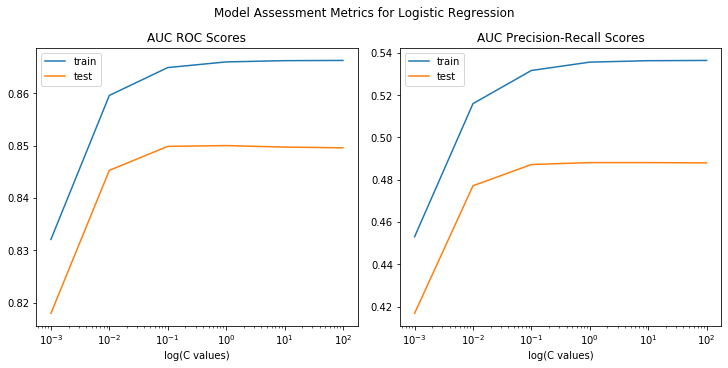

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True)
fig.suptitle('Model Assessment Metrics for Logistic Regression')

axs[0].plot(Cs, train_roc_scores, label='train')
axs[0].plot(Cs, test_roc_scores, label='test')
axs[0].set_xlabel('log(C values)')
axs[0].set_xscale('log')
axs[0].set_title('AUC ROC Scores')
axs[0].legend()

axs[1].plot(Cs, train_pr_scores, label='train')
axs[1].plot(Cs, test_pr_scores, label='test')
axs[1].set_xlabel('log(C values)')
axs[1].set_xscale('log')
axs[1].set_title('AUC Precision-Recall Scores')
axs[1].legend()

plt.show()

The selected hyperparameter used should maximize the test scores while minimizing the difference between the train and test scores (to prevent overfitting towards training data). From the graphs above, the hyperparameter value which best suits the data is C = 1.0. This value will now be used to fit the model again and generate summary statistics (accuracy, ROC AUC, and PR AUC) for the logistic regression model.

In [111]:
best_log_reg = LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000)
best_log_reg.fit(X=X_train, y=y_train)

train_accuracy = best_log_reg.score(X_train, y_train)
test_accuracy = best_log_reg.score(X_test, y_test)

print('train: {}, test: {}'.format(train_accuracy, test_accuracy))

test_pred = best_log_reg.predict_proba(X_test)[:, 1]
    
test_roc_auc = roc_auc_score(y_test, test_pred)
test_pr = average_precision_score(y_test, test_pred)

print('roc_auc: {}, pr_auc: {}'.format(test_roc_auc, test_pr))

train: 0.8796118721461187, test: 0.8741667427632179
roc_auc: 0.8580843954682245, pr_auc: 0.5143492227816958


#### Gradient Boosting Classifier

In [158]:
from sklearn.ensemble import GradientBoostingClassifier

The other model I will be training the data on is the gradient boosting classifier. This model type is generally able to account for a larger number of variables by using a decision tree model. It is a popular model choice for Kaggle data science competitions. My methodology for training and evaluating the gradient boosting classifier will be the same as that for the logistic regression model, however, I will be testing a different parameter - the maximum tree depth that the classifier is allowed to create when generating a decision tree for the model.

In [76]:
# split data for use in evaluating models
X_train, X_test, y_train, y_test = train_test_split(model_matrix.values, model_values.values, test_size = 0.2)

In [82]:
# run train_and_evaluate_model for different tree depths to choose the best one
depths = [2, 3, 4, 5, 6, 7, 8]
train_roc_scores = []
train_pr_scores = []
test_roc_scores = []
test_pr_scores = []

for depth in depths:
    model = GradientBoostingClassifier(max_depth=depth)
    train_roc, train_pr, test_roc, test_pr = train_and_evaluate_model(model, X_train, X_test, y_train, y_test)
    train_roc_scores.append(train_roc)
    train_pr_scores.append(train_pr)
    test_roc_scores.append(test_roc)
    test_pr_scores.append(test_pr)

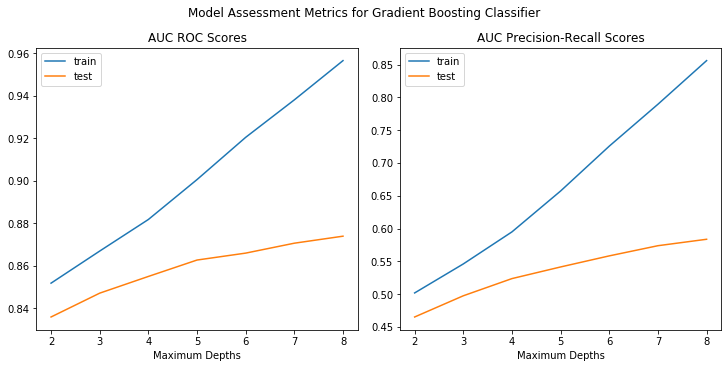

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True)
fig.suptitle('Model Assessment Metrics for Gradient Boosting Classifier')

axs[0].plot(depths, train_roc_scores, label='train')
axs[0].plot(depths, test_roc_scores, label='test')
axs[0].set_xlabel('Maximum Depths')
axs[0].set_title('AUC ROC Scores')
axs[0].legend()

axs[1].plot(depths, train_pr_scores, label='train')
axs[1].plot(depths, test_pr_scores, label='test')
axs[1].set_xlabel('Maximum Depths')
axs[1].set_title('AUC Precision-Recall Scores')
axs[1].legend()

plt.show()

The AUC ROC and PR scores for the Gradient Boosting Classifer are in general better than those of the Logistic Regression model. ROC and PR scores for the model increase with increased tree depths (allowing for more stratification of the variables), however, after a max depth of 4, the increase for the training and testing data sets begins the diverge. This indicates that after a max depth of 4, the gradient boosting classifier is more likely to begin overfitting to the training set. Therefore, I will be using a max depth of 4 for the gradient boosting classifier. The model summary statistics for using a gradient boost classifier with max depth of 4 are printed below.

In [113]:
best_boost = GradientBoostingClassifier(max_depth=4)
best_boost.fit(X=X_train, y=y_train)

train_accuracy = best_boost.score(X_train, y_train)
test_accuracy = best_boost.score(X_test, y_test)

print('train: {}, test: {}'.format(train_accuracy, test_accuracy))

test_pred = best_boost.predict_proba(X_test)[:, 1]
    
test_roc_auc = roc_auc_score(y_test, test_pred)
test_pr = average_precision_score(y_test, test_pred)

print('roc_auc: {}, pr_auc: {}'.format(test_roc_auc, test_pr))

train: 0.8875114155251141, test: 0.878915167564606
roc_auc: 0.8618125165958576, pr_auc: 0.5323643924158833


### Variable Selection with 5-Fold Cross Validation

A model with 312 unique variables may be prohibitive to understanding by the human eye. Therefore, I will be using the SelectKBest feature selection tool from sklearn to select the 50 most impactful variables in model training to assess the model metrics when only those 50 variables are used. To find the 50 most impactful variables, I will perform 5-fold cross validation on my training set. Within each fold, I will split the fold into training and testing data, select the 50 best performing variables, and train the model on the data using only those 50 variables. After all 5 folds have run, I will determine which fold had the best performance and use that fold's variable selection to train the entire training data set, and evaulate on the withheld test set.

In [92]:
# Use stratifed K-folds to approximate equal proportions of mortality rate in each fold
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif

#### Logistic Regression Model (C=1.0)

First, I will perform the 5-fold validation variable selection using the logistic regression model designed above with C = 1.0.

In [91]:
# train-test split to save data for final evaluation
X_train, X_test, y_train, y_test = train_test_split(model_matrix.values, model_values.values, test_size = 0.2)

In [95]:
skf = StratifiedKFold(n_splits=5) # creates 5 stratified folds from the training data
variable_indices = []
test_roc_scores = []

for train_index, test_index in skf.split(X_train, y_train):
    
    # create train and test split for fold
    X_train_k, X_test_k = X_train[train_index], X_train[test_index]
    y_train_k, y_test_k = y_train[train_index], y_train[test_index]
    
    # now, perform variable selection on fold
    selector = SelectKBest(mutual_info_classif, 50)
    selector.fit(X=X_train_k, y=y_train_k)
    
    # store selected variables for later fitting of whole model
    variable_indices.append(selector.get_support(indices=True))
    
    # reduce train and test sets to selected variables
    selector.transform(X_train_k)
    selector.transform(X_test_k)
    
    # fit and evaluate Logistic Regression for fold
    model = LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000)
    train_roc, train_pr, test_roc, test_pr = train_and_evaluate_model(model, X_train_k, X_test_k, y_train_k, y_test_k)
    test_roc_scores.append(test_roc)

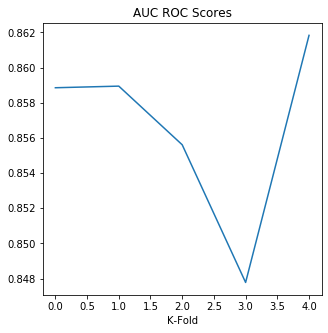

In [97]:
fig, axs = plt.subplots(1, 1, figsize=(5,5))

axs.plot(range(5), test_roc_scores)
axs.set_xlabel('K-Fold')
axs.set_title('AUC ROC Scores')

plt.show()

The model performed the best (had the highest AUC ROC score) using the variables selected in the 5th fold. We will use those variables to train the entire data set and evaulate the model's performance. The 50 variables used are the following:

In [98]:
# view selected variables
model_matrix.columns[variable_indices[4]]

Index(['AGE', '2ndarymalig', 'Acqfootdef', 'Acrenlfail', 'AcuteCVD',
       'Adjustmentdisorders', 'Adltrespfl', 'Asppneumon', 'Bnignutneo',
       'Bone/ctcncr', 'Cardiaarrst', 'Coag/hemrdx', 'Complicproc',
       'Coronathero', 'Dysrhythmia', 'ECodes:Drowning/submersion',
       'ECodes:Fall', 'ECodes:Otherspecifiedandclassifiable',
       'ECodes:Poisoning', 'ECodes:Struckby-against', 'Esophgealdx',
       'Eyeinfectn', 'Fatigue', 'Fluid/elcdx', 'Hemorrpreg', 'Htncomplicn',
       'Hyperlipidem', 'Inducabortn', 'Influenza', 'Intestinfct',
       'Maligneopls', 'Otdxbladdr', 'OtherCVD', 'Othereyedx', 'Othliverdx',
       'Parkinson-s', 'Pleurisy', 'Pneumonia', 'Pulmhartdx', 'Septicemia',
       'Shock', 'Uteruscancr', 'ADMIT_ELECTIVE', 'ADMIT_EMERGENCY',
       'ADMIT_URGENT', 'INSURE_Medicare', 'INSURE_Private', 'MARITAL_WIDOWED',
       'GENDER_M', 'ICU_MICU'],
      dtype='object')

It is unsurprising to see Age as a factor (as explored during data anaylsis, patients experiencing 30 day mortality are skewed towards higher age brackets). It is interesting to note that all three admission type categories were present in the most predictive variables, indicating that admission type may be particularly predictive.

In [114]:
# select best performing variables, transform the entire training set to fit the model, then evaluate
best_vars_X_train = X_train[:, variable_indices[4]]
best_vars_X_test = X_test[:, variable_indices[4]]

limit_lr_model = LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000)
limit_lr_model.fit(X=best_vars_X_train, y=y_train)

train_accuracy = limit_lr_model.score(best_vars_X_train, y_train)
test_accuracy = limit_lr_model.score(best_vars_X_test, y_test)

print('train: {}, test: {}'.format(train_accuracy, test_accuracy))

test_pred = limit_lr_model.predict_proba(best_vars_X_test)[:, 1]
    
test_roc_auc = roc_auc_score(y_test, test_pred)
test_pr = average_precision_score(y_test, test_pred)

print('roc_auc: {}, pr_auc: {}'.format(test_roc_auc, test_pr))

train: 0.8702511415525114, test: 0.8647612090220071
roc_auc: 0.8282112638852008, pr_auc: 0.4331297151306382


Utilizing only 50 variables decreases all evaluation metrics from the original logistic regression model. The accuracy and ROC score are only decreased slightly (these scores are generally higher for unbalanced datasets such as this one), but the PR score dipped significantly with the decreased number of variables.

#### Gradient Boosting Classifier (max_depth = 4)

Now, 5-fold cross-validation will be performed on variable selection for the Gradient Boosting Classifier with max depth of 4.

In [145]:
# train-test split to save data for final evaluation
X_train, X_test, y_train, y_test = train_test_split(model_matrix.values, model_values.values, test_size = 0.2)

In [104]:
skf = StratifiedKFold(n_splits=5) # creates 5 stratified folds from the training data
variable_indices = []
test_roc_scores = []

for train_index, test_index in skf.split(X_train, y_train):
    
    # create train and test split for fold
    X_train_k, X_test_k = X_train[train_index], X_train[test_index]
    y_train_k, y_test_k = y_train[train_index], y_train[test_index]
    
    # now, perform variable selection on fold
    selector = SelectKBest(mutual_info_classif, 50)
    selector.fit(X=X_train_k, y=y_train_k)
    
    # store selected variables for later fitting of whole model
    variable_indices.append(selector.get_support(indices=True))
    
    # reduce train and test sets to selected variables
    selector.transform(X_train_k)
    selector.transform(X_test_k)
    
    # fit and evaluate Gradient Boost for fold
    model = GradientBoostingClassifier(max_depth=4)
    train_roc, train_pr, test_roc, test_pr = train_and_evaluate_model(model, X_train_k, X_test_k, y_train_k, y_test_k)
    test_roc_scores.append(test_roc)

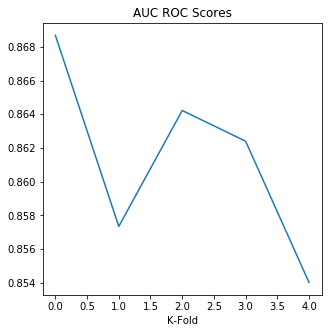

In [106]:
fig, axs = plt.subplots(1, 1, figsize=(5,5))

axs.plot(range(5), test_roc_scores)
axs.set_xlabel('K-Fold')
axs.set_title('AUC ROC Scores')

plt.show()

The fold which provided variable selection that resulted in the best performing model was the first fold. The variables selected for model prediction from the first fold were as follows:

In [107]:
# view selected variables
model_matrix.columns[variable_indices[0]]

Index(['AGE', '2ndarymalig', 'Acrenlfail', 'AcuteCVD', 'Adltrespfl', 'Allergy',
       'Artembolism', 'Asppneumon', 'Backproblem', 'Bone/ctcncr', 'COPD',
       'Cardiaarrst', 'Coag/hemrdx', 'Dysrhythmia', 'ECodes:Cut/pierce',
       'ECodes:Struckby-against', 'Earlylabor', 'Esophgealdx', 'Fluid/elcdx',
       'Fxleg', 'Hd/nckcancr', 'Hrtvalvedx', 'Hyperlipidem', 'Intestinfct',
       'Leukemias', 'Malgenitca', 'Mouthdx', 'Nervcongan', 'Otcirculdx',
       'OtheredCNS', 'Othliverdx', 'Pancreasdx', 'Parkinson-s', 'Pleurisy',
       'Prolapse', 'Screeningandhistoryofmentalhealthan', 'Septicemia',
       'Shock', 'Ulcerskin', 'chf;nonhp', 'ADMIT_ELECTIVE', 'ADMIT_EMERGENCY',
       'INSURE_Medicare', 'INSURE_Private', 'MARITAL_DIVORCED',
       'MARITAL_MARRIED', 'MARITAL_UNKNOWN', 'ETHNICITY_OTHER/UNKNOWN',
       'ICU_CSRU', 'ICU_NICU'],
      dtype='object')

Nearly half (24) of the variables selected by the top performing fold for the Gradient Boosting model were also selected by the top performing fold of the Logistic Regression model. These 24 variables (age, 2ndarymalig, Acrenlfail, AcuteCVD, Adltrespfl, Asppneumon, Bone/ctcncr, Cardiaarrst, Coag/hemrdx, Dysrhythmia, ECodes:Struckby-against, Esophgealdx, Fluid/elcdx, Hyperlipidem, Intestinfct, Othliverdx, Parkinson-s, Pleurisy, Septicemia, Shock, elective admissions, emergency admissions, medicare insurance, and private insurance) may be especially predictive for 30-day mortality.

In [115]:
# select best performing variables, transform the entire training set to fit the model, then evaluate
best_vars_X_train = X_train[:, variable_indices[0]]
best_vars_X_test = X_test[:, variable_indices[0]]

limit_gb_model = GradientBoostingClassifier(max_depth=4)
limit_gb_model.fit(X=best_vars_X_train, y=y_train)

train_accuracy = limit_gb_model.score(best_vars_X_train, y_train)
test_accuracy = limit_gb_model.score(best_vars_X_test, y_test)

print('train: {}, test: {}'.format(train_accuracy, test_accuracy))

test_pred = limit_gb_model.predict_proba(best_vars_X_test)[:, 1]
    
test_roc_auc = roc_auc_score(y_test, test_pred)
test_pr = average_precision_score(y_test, test_pred)

print('roc_auc: {}, pr_auc: {}'.format(test_roc_auc, test_pr))

train: 0.8807762557077625, test: 0.8699662131312209
roc_auc: 0.8401447227938573, pr_auc: 0.4667658564300602


The model statistics for performing gradient boost classification on the top 50 selected variables again decrease from the performance of the model on all variables. The primary area of decrease is once again the precision recall AUC score. However, training the Gradient Boosting classifier on 50 variables still performs better than trianing the logistic regression model on 50 variables.

### Summary Statistics for Models

As shown in Table 1, the Gradient Boosting Classifier consistently performs better than the logisitic regression model. Utilizing only 50 variables to train the models, while perhaps resulting in an easier to understand model, significantly decreases the quality of the model. This effect is primarily seen the precision recall score, due to the uneven distribution of dataset entries (~86% no 30-day mortality). When utilizing only 50 variables, the models perform under the precision-recall benchmark of 0.500.

Table 1: Metrics for Tested Models

| Model Type | Test Accuracy | ROC AUC Score | PR AUC Score |
| --- | --- | --- | --- |
| Logistic Regression (All Vars) | 0.874 | 0.858 | 0.514 |
| Gradient Boosting (All Vars) | 0.879 | 0.862 | 0.532 |
| Logistic Regression (Best 50 Vars) | 0.865 | 0.828 | 0.433 |
| Gradient Boosting (Best 50 Vars) | 0.870 | 0.840 | 0.467 |


To further visualize the data represented above for the Logistic Regression and Gradient Boosting models (with all variables considered), below is a plot of the ROC curves and PR curves for each model, vs. the benchmark line for each respective curve.

In [148]:
from sklearn.metrics import roc_curve, precision_recall_curve

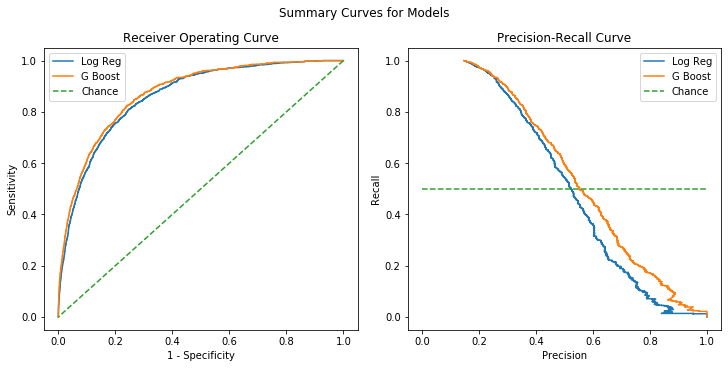

In [154]:
spec1, sens1, thresholds = roc_curve(y_test, best_log_reg.predict_proba(X_test)[:, 1])
spec2, sens2, thresholds = roc_curve(y_test, best_boost.predict_proba(X_test)[:, 1])

pr1, rec1, thresholds = precision_recall_curve(y_test, best_log_reg.predict_proba(X_test)[:, 1])
pr2, rec2, thresholds = precision_recall_curve(y_test, best_boost.predict_proba(X_test)[:, 1])

fig, axs = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True)
fig.suptitle('Summary Curves for Models')

axs[0].plot(spec1, sens1, label='Log Reg')
axs[0].plot(spec2, sens2, label='G Boost')
axs[0].plot([1, 0],[1, 0], linestyle = "--", label='Chance')
axs[0].set_xlabel('1 - Specificity')
axs[0].set_ylabel('Sensitivity')
axs[0].set_title('Receiver Operating Curve')
axs[0].legend()

axs[1].plot(pr1, rec1, label='Log Reg')
axs[1].plot(pr2, rec2, label='G Boost')
axs[1].plot([0, 1], [0.5, 0.5], linestyle= "--", label='Chance')
axs[1].set_xlabel('Precision')
axs[1].set_ylabel('Recall')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend()

plt.show()

As confirmed by the AUC scores, the plots above demonstrate consistently higher performance for the Gradient Boosting Classifier than the Logistic Regression model.

To examine the calibration of the models, calibration curves were plotted for each. As show below, the models are generally fairly well calibrated, falling closely along the balanced line. The logistic regression curve tends to overestimate risk, at times giving a higher probability of 30-day mortality than is empirically expected. The gradient boosting classifier, on the other hand, tends to underestimate risk, generally giving a lower probability of 30-day mortality than is generally expected. Therefore, when erring on the side of caution (as is generally preferred when mortality is a factor), the logistic regression model may be better calibrated towards making predictions.

In [155]:
from sklearn.calibration import calibration_curve

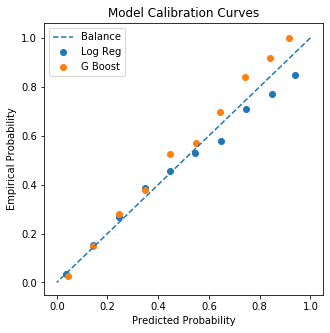

In [157]:
y_axis1, x_axis1 = calibration_curve(y_test, best_log_reg.predict_proba(X_test)[:, 1], n_bins = 10)
y_axis2, x_axis2 = calibration_curve(y_test, best_boost.predict_proba(X_test)[:, 1], n_bins = 10)

fig, axs = plt.subplots(1, 1, figsize=(5,5))

axs.scatter(x_axis1, y_axis1, label='Log Reg')
axs.scatter(x_axis2, y_axis2, label='G Boost')
axs.plot([1, 0],[1, 0], linestyle = "--", label='Balance')
axs.set_xlabel('Predicted Probability')
axs.set_ylabel('Empirical Probability')
axs.set_title('Model Calibration Curves')
axs.legend()

plt.show()

## Suggestions

Considering the results from the Modeling section, the best model to use (of those examined) to predict 30-Day Mortality at the time of hospital admission is the Gradient Boosting Classifier with all 312 variables considered. However, the Gradient Boosting Classifier still does not provide a significant improvement over a benchmark of selecting the non-mortality option for each patients. This benchmark would have 0.864 accuracy and 0.500 AUC precision-recall. My model has an accuracy of 0.879 and a 0.532 AUC precision-recall, meaning it performs only slightly better than this basic benchmark. Similarly to the benchmark, my model also tends to under-predict 30-day mortality, being slightly over calibrated to the non-mortality case. If this model were to enter production, I would recommend that the Gradient Boosting Classifier be used, but that data outside of that obtained at the start of the admission be used. One method that would generate more numerical variables of significance would be to include chart data for the patient within the first 24 hours of their admission. Chart data includes variables of interest such as patient heart rate and blood pressure, and the minimum, mean, and maximum of these values may prove predictive. Utilizing the first 24 hours of a patients data would also open up common testing results to being used in the model matrix. Including more variables is likely to generate a model that is more predictive to the general hospital admission population. Therefore, if I were to incorporate this model into hospital use, I would train it on more variables (primarily numeric chart/lab data) that may provide heavier influence on 30-day mortality. Then, after the model was fit to those variables, for each unique admission the values for each variable could be keyed in after 24 hours and the model would predict the likelihood of patient mortality within the subsequent 29 days.

## Conclusions

The aim for this project was to create a predictive model that would take in static patient variables obtained at the time of admission and predict whether the patient was likely to die within 30 days of their admission time. Utilizing the MIMIC-III dataset, I was able to identify 8 general variable categories (admission type, insurance type, marital status, age, ethnicity, gender, ICU stay type, and unique CCS categories diagnosed) that generated 312 unique features of a patient admission. I then trained two different popular model types on this data to predict 30-day mortality for patients, and was able to generate results slighlty improved from a general benchmark that predicted no patients would experience 30-day mortality. The features used in this classification task appear to not be predictive enough to generate significant model quality (based on model metrics of AUC ROC and precision-recall scores), so a suggestion for implementation of this task in true hospitals would be to use data from the first 24 hours of admissions. This would still allow for enough time to evaluate patient likelihood of 30-day mortality prior to death (allowing hospitals the time to improve their standard of care for that patient), and would generate more features for the gradient boost classification model to predict on - features which are likely to be more predictive of mortality than those encapsulated by the categorical data acquired on admission. One barrier to this model's success, even with including data from the first 24 hours of a patients hospital stay, would be encouraging doctors to accept the model's predictivity. Even if the metrics of the model were greatly improved by using these additional factors, humans are generally unlikely to accept that entering patient data obtained from static and chart/lab sources within the first 24 hours of a patient stay will be more predictive of mortality than a doctors prognosis. This sort of barrier will continue to provide challenges for the data science in healthcare until major breakthroughs are made.

## Resources

Gao, Michael. (2020). HW2 - Pandas and ICD9-Codes. Duke University BME590 Data Science and Health.

H-CUP. (2017, March 6). Clinical Classifications Software (CCS) for ICD-9-CM. Retrieved from https://hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp

Johnson, A., Pollard, T., & Mark, R. (2016, September 4). MIMIC-III Clinical Database. Retrieved from https://physionet.org/content/mimiciii/1.4/

Johnson, A. E. W., Pollard, T. J., Shen, L., Lehman, L.-wei H., Feng, M., Ghassemi, M., … Mark, R. G. (2016, May 24). MIMIC-III, a freely accessible critical care database. Retrieved from https://www.nature.com/articles/sdata201635

Medicare.gov. (n.d.). 30-day death (mortality) rates. Retrieved from https://www.medicare.gov/hospitalcompare/Data/Death-rates.html